In [ ]:
from keras.datasets import cifar10
import numpy as np
import tensorflow as tf
import random

np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Done loading data")

Done loading data


In [ ]:
import numpy as np
def psnr(x_test_pred, x_test):
  psnrs=[]
  for pred, inp  in zip(x_test_pred, x_test):
    mse = np.mean((pred-inp)**2)
    # if mse==0:
    #   mse = 100
    psnr = 20*np.log10(1/np.sqrt(mse)) if mse!=0 else 100
    psnrs.append(psnr)
  mean_psnr = np.mean(psnrs)
  stddev_psnr = np.std(psnrs)
  return mean_psnr,stddev_psnr

In [ ]:
from keras.models import Sequential
from keras.layers import GaussianNoise, Input
from keras.models import Model
import keras
import numpy as np
import tensorflow as tf

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_layer = tf.keras.layers.Input(shape=(32,32,3))
gaus = tf.keras.layers.GaussianNoise(0.1)(input_layer)
model = tf.keras.models.Model(inputs=input_layer, outputs=gaus)

# input_layer = Input(shape=(1, 32,32,3))
# output_layer = GaussianNoise(0.1)(input_layer, training=True)

# model = Model(inputs = input_layer, outputs=output_layer)

x_train_noise = model(x_train, training=True)
x_test_noise = model(x_test, training=True)
mean,std = psnr(x_test_noise, x_test)

print(f"PSNR mean {mean} ad std dev {std}")

PSNR mean 19.99724360420243 ad std dev 0.11045917124345905


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

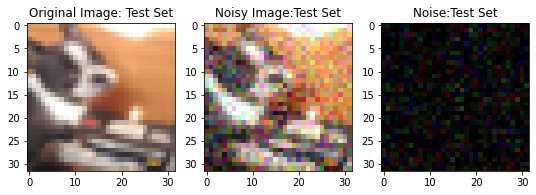

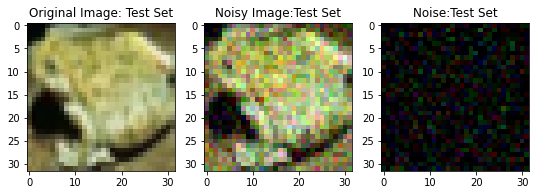

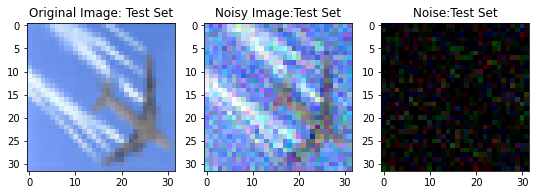

In [ ]:
from matplotlib import pyplot as plt

train_images_ind = np.random.choice(range(x_train.shape[0]), 3)
test_image_ind = np.random.choice(range(x_test.shape[0]), 3)

for ind in zip(train_images_ind,test_image_ind):
  og_image_train = x_train[ind[0]]
  noisy_image_train = x_train_noise[ind[0]]
  noise_train = noisy_image_train - og_image_train
  og_image_test = x_test[ind[1]]
  noisy_image_test = x_test_noise[ind[1]]
  noise_test = noisy_image_test - og_image_test

  fig,(ax1,ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
  for i in [("Train Set",og_image_train, noisy_image_train, noise_train), ("Test Set",og_image_test, noisy_image_test, noise_test)]:  
    ax1.set_title('Original Image: {}'.format(i[0]))
    ax1.imshow(i[1])
    ax2.set_title("Noisy Image:{}".format(i[0]))
    ax2.imshow(i[2])
    ax3.set_title("Noise:{}".format(i[0]))
    ax3.imshow(i[3])
  fig.savefig(f'/content/drive/My Drive/noise_image_{ind}.png')
 

In [ ]:
from keras.layers import Conv2D, BatchNormalization, Activation, Add, Subtract, AveragePooling2D, Input
from keras.initializers import glorot_uniform
conv_name_base="res{}{}_branch"
bn_name_base="bn{}{}_branch"

def identity_block(X,k,num_filters, stage, block,s=1):
  conv_name_base="res{}{}_branch".format(stage,block)
  bn_name_base="bn{}{}_branch".format(stage,block)

  X_shortcut = X

  X = Conv2D(filters=num_filters[0], strides=(s,s), kernel_size=(k,k),
             padding='same', kernel_initializer=glorot_uniform(seed=0), 
             name = conv_name_base+"2a")(X)
  # x = BatchNormalization(axis=3, name= bn_name_base+"2a")(x)
  X = Activation('relu')(X)

  # x = Conv2D(filters=num_filters[1], strides=(s,s), kernel_size=(k,k),
  #            padding='same', kernel_initializer=glorot_uniform(seed=0), 
  #            name = conv_name_base+"2b")(X)
  # x = BatchNormalization(axis=3, name= bn_name_base+"2b")(x)
  # x = Activation('relu')(x)


  X = Conv2D(filters=num_filters[2], strides=(s,s), kernel_size=(k,k),
             padding='same', kernel_initializer=glorot_uniform(seed=0), 
             name = conv_name_base+"2c")(X)
  # x = BatchNormalization(axis=3, name= bn_name_base+"2c")(x)

  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)



  
  return X

def convolutional_block(X,k,s,num_filters,stage,block):
  conv_name_base="res{}{}_branch".format(stage,block)
  bn_name_base="bn{}{}_branch".format(stage,block)

  X_shortcut = X

  X = Conv2D(filters=num_filters[0], strides=(s,s), kernel_size=(k,k),
             padding='same', kernel_initializer=glorot_uniform(seed=0), 
             name = conv_name_base+"2a")(X)
  # x = BatchNormalization(axis=3, name= bn_name_base+"2a")(x)
  X = Activation('relu')(X)

  # x = Conv2D(filters=num_filters[1], strides=(1,1), kernel_size=(k,k),
  #            padding='same', kernel_initializer=glorot_uniform(seed=0), 
  #            name = conv_name_base+"2b")(X)
  # x = BatchNormalization(axis=3, name= bn_name_base+"2b")(x)
  # x = Activation('relu')(x)


  X = Conv2D(filters=num_filters[2], strides=(1,1), kernel_size=(k,k),
             padding='same', kernel_initializer=glorot_uniform(seed=0), 
             name = conv_name_base+"2c")(X)
  # x = BatchNormalization(axis=3, name= bn_name_base+"2c")(x)
  

  X_shortcut = Conv2D(filters=num_filters[2], strides=(s,s), kernel_size=(1,1),
             padding='same', kernel_initializer=glorot_uniform(seed=0), 
             name = conv_name_base+"1")(X_shortcut)
  # X_shortcut = BatchNormalization(axis=3, name= bn_name_base+"1")(X_shortcut)
  X= Add()([X, X_shortcut])
  X = Activation('relu')(X)
  return X

In [ ]:
from keras import Model
X_input = Input((32,32,3))

X = Conv2D(64, (3,3), strides = (1, 1), name = 'conv1', kernel_initializer = 
           glorot_uniform(seed=0), padding='same')(X_input)
# X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)

# X = convolutional_block(X, k = 3, num_filters = [128, 128, 256], stage = 2, block='a', s = 1)
X = identity_block(X, 3, [64,64,64], stage=2, block='b')
X = identity_block(X, 3, [64,64,64], stage=2, block='c')
# X = convolutional_block(X, k = 3, num_filters = [64, 64, 64], stage = 3, block='a', s = 1)
X = identity_block(X, 3, [64,64,64], stage=3, block='b')
# X = identity_block(X, 3, [64,64,64], stage=3, block='c')
# X = convolutional_block(X, k = 3, num_filters = [128, 128, 128], stage =4, block='a', s = 1)
# X = identity_block(X, 3, [64,64,64], stage=4, block='b')
# X = identity_block(X, 3, [128, 128, 128], stage=4, block='c')
# X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
X = Conv2D(3,(3,3),strides=(1,1), name='conv_last', kernel_initializer=glorot_uniform(seed=0), padding='same')(X)


X = Subtract()([X_input, X])
# X = Activation('relu')(X)

model = Model(inputs = [X_input], outputs = [X], name='ResNet')

print(model.summary())


Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
res2b_branch2a (Conv2D)         (None, 32, 32, 64)   36928       activation_1[0][0]               
_____________________________________________________________________________________________

In [ ]:
from keras.metrics import MeanSquaredError
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import keras 
import numpy as np
batch_size = 128
# X_noise_train_datagen = ImageDataGenerator(validation_split=0.1)
# X_train_datagen = ImageDataGenerator(validation_split=0.1)
# train_noise_gen = X_noise_train_datagen.flow(x_train_noise, batch_size=batch_size)
# train_input_gen = X_train_datagen.flow(x_train, batch_size=batch_size)
# train_gen = zip(train_noise_gen, train_input_gen)
x_train_noise = np.array(x_train_noise)
x_test_noise = np.array(x_test_noise)
early_stopping = EarlyStopping(monitor = "val_mean_squared_error", 
                               min_delta = 0.0000, patience=3, 
                               restore_best_weights=True, mode='min')
opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer=opt, loss='mse', metrics=[MeanSquaredError()])
model.fit(x=x_train_noise, y=x_train, batch_size=batch_size, epochs=10, validation_split=0.1)
# model.fit_generator(train_gen, epochs=25, steps_per_epoch=50000/batch_size)



Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 18s 410us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/10
45000/45000 [==============================] - 12s 270us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/10
45000/45000 [==============================] - 12s 269us/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
45000/45000 [==============================] - 12s 270us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/10
45000/45000 [==============================] - 12s 273us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/10
45000/45000 [==============================] - 12s 269us/step - loss: 0.0016 - mean_squared_err

In [ ]:
# import os
# save_dir = '/content/drive/My Drive/model/'
# model_name = 'keras_resent_denoising_trained_model_noskip.h5'

# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

NameError: ignored

In [ ]:
import numpy as np
from keras.metrics import MeanSquaredError
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.models import load_model
import os

# save_dir = '/content/drive/My Drive/model/'
# model_name = 'keras_resent_denoising_trained_model_noskip.h5'
# model_path = os.path.join(save_dir, model_name)

# model = load_model(model_path)
# print(model.summary())
x_test_pred = model.predict(x_test_noise,batch_size=batch_size)
print(x_test_pred.shape)
print("Done predicting")

mean_psnr, stddev_psnr = psnr(x_test_pred, x_test)
print("Mean and standard deviation PSNR of test set are {} and {}".format(mean_psnr, stddev_psnr))

(10000, 32, 32, 3)
Done predicting
Mean and standard deviation PSNR of test set are 28.434088750834892 and 1.2690695611541407


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


235
348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


908
382


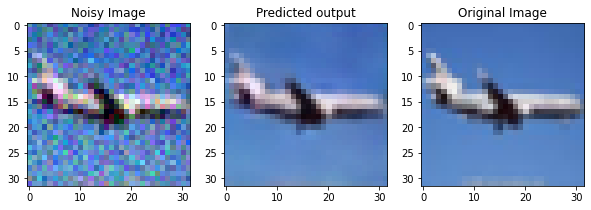

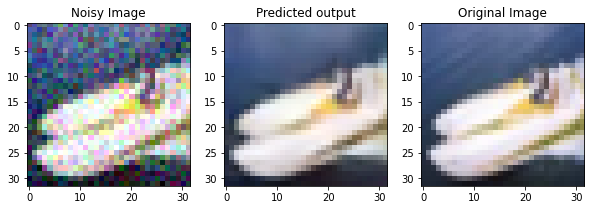

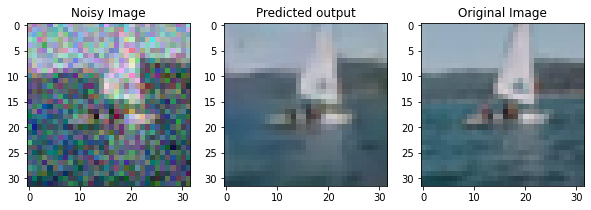

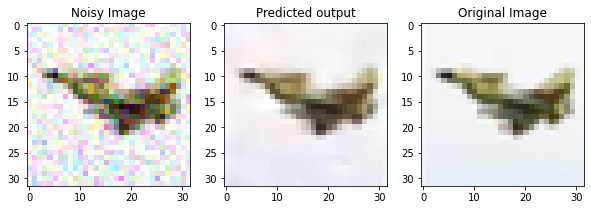

In [ ]:
from matplotlib import pyplot as plt
np.random.seed(10)
choices= np.random.choice(range(1000),size=3)
choices=[235,348,908,382]
for index in choices:
  print(index)
  noisy_image = x_test_noise[index]
  output = x_test_pred[index]
  original_image = x_test[index]
  fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,3))
  ax1.set_title("Noisy Image")
  ax1.imshow(noisy_image)
  ax2.set_title("Predicted output")
  ax2.imshow(output)
  ax3.set_title("Original Image")
  ax3.imshow(original_image)
  fig.savefig(f'/content/drive/My Drive/recoverywithskip_{index}.png')


In [ ]:
import numpy as np

# choices= np.random.choice(range(1000),size=3)
choices = [448, 807, 429]
for index in choices:
  noisy_image = x_test_noise[index]
  output = x_test[index]

  fig,(ax1,ax2) = plt.subplots(1,2)
  ax1.set_title("Noisy Image")
  ax1.imshow(noisy_image)
  ax2.set_title("Net output")
  ax2.imshow(output)
  plt.show()